In [1]:
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import sys

sys.path.append("../")

from src.common_functions import *

In [3]:
# sample data
RAW_DATA_PATH = "../datasets/fraud/fin_fraud.csv"
SAMPLED_DATA_PATH = f"{RAW_DATA_PATH.split('.csv')[0]}_1.csv"
DATASET_NAME = Path(SAMPLED_DATA_PATH).stem
raw_data = pd.read_csv("../datasets/fraud/fin_fraud.csv")
raw_data = raw_data.rename(columns=dict(zip(raw_data.columns, list(map(to_snake_case, raw_data.columns)))))
raw_data.head()
_to_drop, df = train_test_split(raw_data, test_size=0.1, random_state=42, stratify=raw_data["fraud"])
df.to_csv(SAMPLED_DATA_PATH, header=True, sep=",")
del _to_drop
print(df.shape[0])
df.fraud.value_counts()/df.shape[0]*100

100000


fraud
0.0    91.26
1.0     8.74
Name: count, dtype: float64

In [4]:
df.isna().any()

distance_from_home                False
distance_from_last_transaction    False
ratio_to_median_purchase_price    False
repeat_retailer                   False
used_chip                         False
used_pin_number                   False
online_order                      False
fraud                             False
dtype: bool

In [5]:
y = "fraud"

# some generic cleaning

COLUMNS_TO_DROP = []
assert df[y].isna().any() == False
raw_features = df.drop(COLUMNS_TO_DROP, axis=1)

# ML tuning

train, test = train_test_split(
    raw_features, test_size=0.2, random_state=0, stratify=df[y])

fit_le = LabelEncoder().fit(train[y])

In [6]:
param_grid = {
    'logistic__penalty': ['l2'],
    'logistic__C': [1, 10, 100, 1000],
    'pca__n_components': [6,8,10,12],
    'under__sampling_strategy': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    'over__sampling_strategy': [0.2, 0.3, 0.4, 0.5, 0.7, 1]
}

model = LogisticRegression()

MODEL_NAME = 'logistic'

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, model=model, fit_le=fit_le, model_name='logistic', param_grid=param_grid)
best_pipeline_log_reg = grid.best_estimator_
best_pipeline_log_reg

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


/home/maarten/.local/share/virtualenvs/End-to-end-project---Customer-churn-PLUo0CZ0/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
2520 fits failed out of a total of 2880.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1440 fits failed with the following error:
Traceback (most recent call last):
  File "/home/maarten/.local/share/virtualenvs/End-to-end-project---Customer-churn-PLUo0CZ0/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/maarten/.local/share/virtualenvs/End-to-end-project---Customer-churn-PLUo0CZ0/lib/python3.11/site-packages/imblearn/pipeline.py", line 293, in fit
   

Best score: 0.9784344218431678
Best parameters: {'logistic__C': 1, 'logistic__penalty': 'l2', 'over__sampling_strategy': 1, 'pca__n_components': 6, 'under__sampling_strategy': 0.5}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['distance_from_home',
                                                   'distance_from_last_transaction',
                                                   'ratio_to_median_purchase_price',
                                                   'repeat_retailer',
                                                   'used_chip',
                                                   'used_pin_number',
                                                   'online_order']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  [])])),
                ('under', RandomUnderSampler(sampling_strategy=0.5)),
                ('over', SMOTE(sampling_strategy=1)),
                ('pca', PCA(n_components=6)),
                ('logistic', LogisticRegression(C=1))])

In [7]:
write_pipeline(best_pipeline_log_reg, MODEL_NAME, DATASET_NAME)

In [8]:
COLUMNS = ["under__sampling_strategy", "over__sampling_strategy", "pca__n_components", f"{MODEL_NAME}__C", f"{MODEL_NAME}__penalty", "roc_auc_mean", "roc_auc_std"]

pd.concat([
    pd.DataFrame(grid.cv_results_["params"]),
    pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["roc_auc_mean"]),
    pd.DataFrame(grid.cv_results_["std_test_score"], columns=["roc_auc_std"])
    ],axis=1).dropna(subset=["roc_auc_mean", "roc_auc_std"])[COLUMNS].sort_values(by=COLUMNS)

,under__sampling_strategy,over__sampling_strategy,pca__n_components,logistic__C,logistic__penalty,roc_auc_mean,roc_auc_std
0,0.1,0.2,6,1,l2,0.973622,0.002508
144,0.1,0.2,6,10,l2,0.973492,0.002703
288,0.1,0.2,6,100,l2,0.973743,0.002344
432,0.1,0.2,6,1000,l2,0.973748,0.002550
24,0.1,0.3,6,1,l2,0.974852,0.002079
...,...,...,...,...,...,...,...
555,0.5,1.0,6,1000,l2,0.978130,0.000483
124,0.7,1.0,6,1,l2,0.977883,0.000455
268,0.7,1.0,6,10,l2,0.977919,0.000822
412,0.7,1.0,6,100,l2,0.977872,0.000681


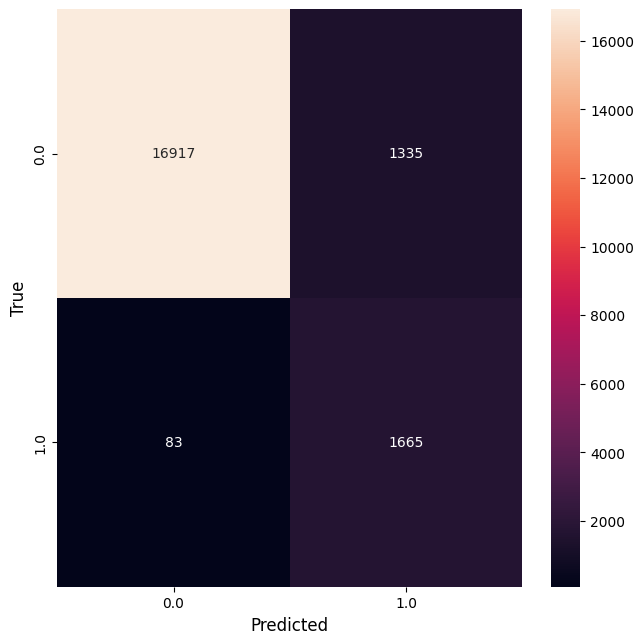

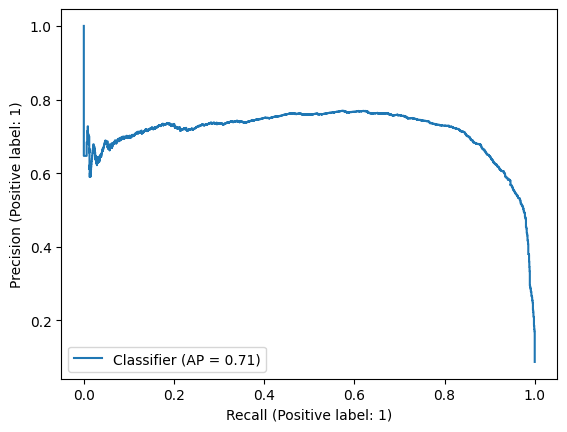

In [9]:
evaluate_model(best_pipeline_log_reg, fit_le=fit_le, test=test, y_col_name=y)